<a href="https://colab.research.google.com/github/Jinyong-20/Machine_Learning_Programming/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


\# 드라이브 마운트 및 함수 임포트
%matplotlib inline - 그림으로 표현

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [4]:
path = Config().data_path()/'mnist'
path.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

\# 디렉토리 생성 및 패스 설정

In [5]:
path

PosixPath('/root/.fastai/data/mnist')

In [6]:
! mv '/content/gdrive/My Drive/Colab Notebooks/mnist.pkl.gz' '/root/.fastai/data/mnist'

mv: cannot stat '/content/gdrive/My Drive/Colab Notebooks/mnist.pkl.gz': No such file or directory


\# 직접 파일 업로드 후 이동

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

\# 패스 경로에 위치한 파일 출력

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

\# 경로에 있던 압축파일을 압축 풀기
- 유니코드로 인코딩하여 로드

In [9]:
doc(plt.imshow)

(50000, 784)

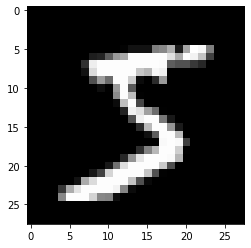

In [10]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

\# 이미지로 출력, 색상은 회색, 사이즈는 28x28로

In [11]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

\# tensor에 매핑, n,c에 x_train 사이즈 저장, y_train최대 최소 출력

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

\# 배치사이즈는 64, tensor 데이터 셋 생성, 데이터 번치 생성

In [13]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [14]:
help(data)

Help on DataBunch in module fastai.basic_data object:

class DataBunch(builtins.object)
 |  Bind `train_dl`,`valid_dl` and `test_dl` in a data object.
 |  
 |  Methods defined here:
 |  
 |  __getattr__(self, k:int) -> Any
 |  
 |  __init__(self, train_dl:torch.utils.data.dataloader.DataLoader, valid_dl:torch.utils.data.dataloader.DataLoader, fix_dl:torch.utils.data.dataloader.DataLoader=None, test_dl:Union[torch.utils.data.dataloader.DataLoader, NoneType]=None, device:torch.device=None, dl_tfms:Union[Collection[Callable], NoneType]=None, path:Union[pathlib.Path, str]='.', collate_fn:Callable=<function data_collate at 0x7f5ccb36b400>, no_check:bool=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self) -> str
 |      Return repr(self).
 |  
 |  __setstate__(self, data:Any)
 |  
 |  add_test(self, items:Iterator, label:Any=None, tfms=None, tfm_y=None) -> None
 |      Add the `items` as a test set. Pass along `label` otherwise label them wit

\# x,y를 데이터 셋의 다음 데이터로 이동, 사이즈 출력

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

\# 바이어스가 있는 선형레이어를 한 개 가지는 클래스 생성

In [0]:
model = Mnist_Logistic().cuda()

In [17]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

\# 모델 출력
바이어스가 있는 선형 레이어, in  784, out 10

In [18]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [19]:
model(x).shape

torch.Size([64, 10])

\# x를 모델 형태로 사이즈 출력

In [20]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

\# 모델의 파라미터의 사이즈 모두 출력

In [0]:
lr=2e-2

\# 학습율 설정

In [0]:
loss_func = nn.CrossEntropyLoss()

\# 손실 함수

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

\# 학습율에 따른 업데이트 함수 정의


x = torch.ones(n,2) 


def mse(y_hat, y): return ((y_hat-y)**2).mean()


y_hat = x@a


의 내용을 수행하여 손실을 계산




In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

\# 손실 업데이트를 데이텅 셋의 데이터를 인자로 수행

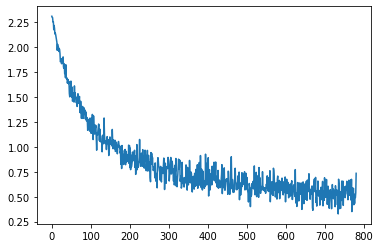

In [25]:
plt.plot(losses);

\# 업데이트 된 손실 계산을 그래프로 출력

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

\# 선형레이어를 2개 가지는 클래스 생성

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

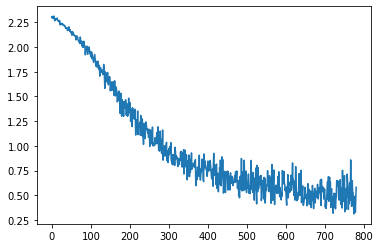

In [29]:
plt.plot(losses);

\# 선형 레이터 2개를 바탕으로 위의 손실 계산을 그대로 수행, 출력

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

\# 업데이트 함수 재정의, opt = 가중치를 계산할 optimizer


step() = 매개변수 갱신


zero_grad() = 갱신할 변수들에 대한 모든 변화도를 0으로 

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

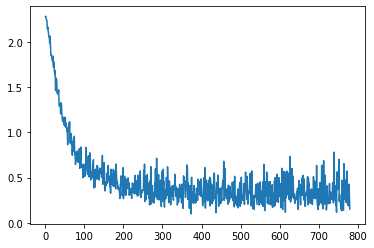

In [33]:
plt.plot(losses);

\# 위의 학습 및 손실 계산 후 그래프 출력

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

\# 생성한 클래스를 모델로 러너 생성

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


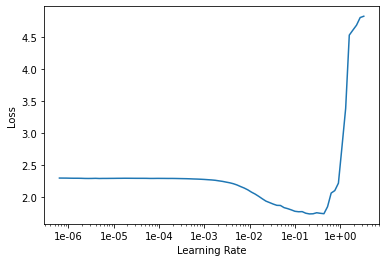

In [35]:
learn.lr_find()
learn.recorder.plot()

\# 학습율 최적값 탐색, 그래프로 출력

In [36]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.143503,0.133811,0.959100,00:05


\# 1획 학습, 학습율 1e-2

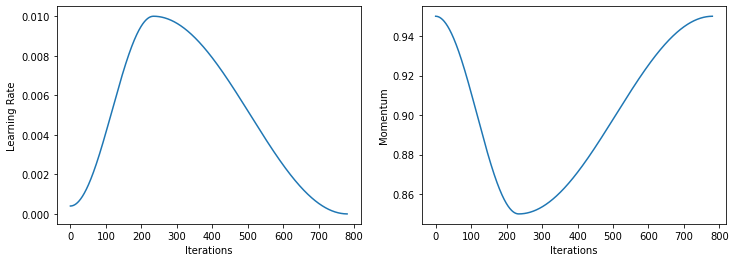

In [37]:
learn.recorder.plot_lr(show_moms=True)

\# 이터레이션 진행에 따른 학습율, 모멘텀 그래프 출력

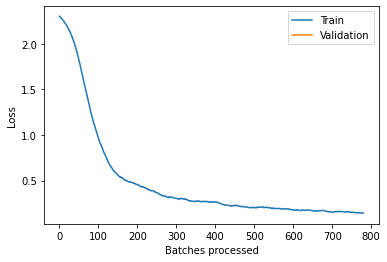

In [38]:
learn.recorder.plot_losses()

## fin